# [JPX] Add new features? (日本語/Eng)

Updated on 7-May for method (1.5)

This is the first time for me to participate in the competition held by Japanese organization, so I'm a bit happy and excited.  
In this competition, I tried to see how Public Score is changed, by adding various new features.  
However, currently I have a hard time trying to improve the score. The current situation is that it seems the best way simply to use the Open/Close/High/Low/Volume information only, rather than trying to play various cheap tricks...

日本企業/団体が開催するコンペに参加するのは初めてなので、なんとなく嬉しいです♪  
今回は、LightGBMを使って、いろいろと特徴量を加えてみてPublic Scoreがどう改善するかを試してみました。  
ただ、今のところかなり苦戦しており、実は変に小細工せず、「始値・終値・高値・安値・取引量」の情報をそのまま投入するのが一番スコアが良いという予想外の状況になっています。

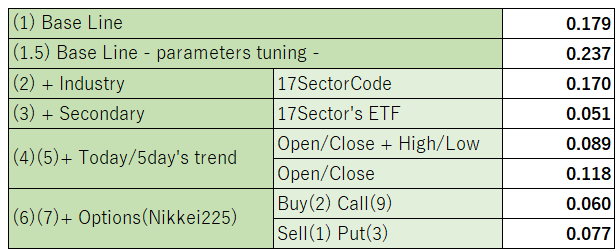

(I tried to utilize Financials as well, but still am suffering from myterious Scoring Error...)
（Financialsの情報も使おうと思ったのですが、謎のScoring errorに苦しんでいます。。。）

# Import libraries and Files 

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [ ]:
import numpy as np
import pandas as pd
import jpx_tokyo_market_prediction
from lightgbm import LGBMRegressor
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)

In [ ]:
train_prices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv")
train_options = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/options.csv")
train_secondary = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/secondary_stock_prices.csv")
train_financials = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/train_files/financials.csv")
supplemental_prices = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/supplemental_files/stock_prices.csv")
supplemental_options = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/supplemental_files/options.csv")
supplemental_financials = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/supplemental_files/financials.csv")
stock_list = pd.read_csv("../input/jpx-tokyo-stock-exchange-prediction/stock_list.csv")

In [ ]:
stock_list.head()

# (1) Baseline

First, try to feed simply "Open/Close/High/Low/Volume" information only.  
Public Score shows **0.179**.
(At this moment, this is the highest score, though I'll hereafter try to add various new features.) 

まずは、シンプルに「始値・終値・高値・安値・取引量」だけをLightGBMに投入してみます。  
Public Scoreは、**0.179**。


In [ ]:
feature_cols = ["Date", "SecuritiesCode", "Open", "High", "Low", "Close", "Volume"]

def create_data(df) :    
    df = df[feature_cols].copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].dt.strftime("%Y%m%d").astype(int)
    return df

In [ ]:
X_train = create_data(train_prices)
y_train = train_prices["Target"].copy()
X_train.head()

# (1.5) Parameters tuning

Thanks to [higuuu](https://www.kaggle.com/higuuu)'s comment,I treid a slight parameter tuning, which contributed to unexpected improvement in Public Score from 0.179 to **0.237**.

higuuuさんからパラメーターの調整でスコアが改善したとのコメントをいただき、私も少し試してみました。期待以上のスコア改善となり（0.179→**0.237**）やや驚きです。

In [ ]:
lgb_params = {
    "objective": "regression",
    'metric': 'rmse',
    "n_estimators" : 200,
    "num_leaves" : 60,
    "learning_rate" : 0.1,
    "random_seed" : 10}

In [ ]:
#lgb_params = {
#    "objective": "regression",
#    "n_estimators" : 300,
#    "num_leaves" : 300,
#    "learning_rate" : 0.1,
#    "random_seed" : 1234}
    
model = LGBMRegressor(**lgb_params)
    
model.fit(X_train, y_train)

In [ ]:
env = jpx_tokyo_market_prediction.make_env()
iter_test = env.iter_test()

In [ ]:
for (prices, options, financials, trades, secondary_prices, sample_prediction) in iter_test:
    
    display(prices)    
    df = create_data(prices)
        
    sample_prediction["Prediction"] = model.predict(df)
    sample_prediction = sample_prediction.sort_values(by = "Prediction", ascending=False)
    sample_prediction['Rank'] = np.arange(0,2000)
    sample_prediction = sample_prediction.sort_values(by = "SecuritiesCode", ascending=True)
    sample_prediction.drop(["Prediction"],axis=1)
    submission = sample_prediction[["Date","SecuritiesCode","Rank"]].copy()
    env.predict(submission)
    display(submission)

Training data is up to 2021/12/03. After the next business day(12/06), Submission API will provide everyday's information , and this competition is to predict the everyday's profitability ranking of each stock.  
FYI, the csv files starting from "Supplimental_" includes prediction period's information, therefore, if you use these files for learning, the score will show extraordinary high score due to data leak and overfitting.  

トレーニングのデータは2021年12月03日までとなっており、提出用APIではその翌営業日の12月06日から一日単位でトレーニングと同じ情報が提供され、それをもとに各株式の収益率ランキングを予想するようです。  
なお、Supplimentalという名前のファイルはこの予測期間である12月06日以降の情報なので、このファイルをそのまま学習に使うとData Leakにより高得点が出てしまいます。

# (2) Add "Industry" feature
​
As you can see in the above Stock_list column "17SectorCode", company's stocks are classfied as 17 industrial sectors (E.G., SectorCode 1 means "Food" industry.)   
FYI, the reason why the next row SecuritiesCode1305 does not have SectorCode is because this is ETF.  ETF is secondarily issued binding multiple company's stocks or bonds, and hence ETF itself does not belong to any industries. That's why these ETF's information is not included in stock_prices file but separately included in secondary_stock_prices file.  

Let's add this "Industry" feature in the training data.  
The result is, Public Score shows **0.170**, which is a bit worse than Baseline.


上記のStock_listのカラムにも見える通り、一般企業の株式は「17SectorCode」で17業種に分類されているようです（１はFood＝食品業種のようですね）。  
ちなみに、次のコード番号1305の業種コードがないのは、これが投資信託だからです。投資信託は企業が発行する株式や債券を一つに束ねて二次的に発行するものなので投資信託自体に業種は存在しません。なお、”二次的に”（セカンダリー）発行されるものなので、このコンペのファイルでもstock_pricesには含まれておらず、secondary_stock_pricesという別ファイルで扱われています（直接コンペの対象にはなっていません）。

この「業種」を学習データに加えてみます。以下のコードを実行すれば17SectorCodeが追加されます。  
結果、Public Scoreは**0.170**と若干低下しました。

In [ ]:
stock_list["17SectorName"].unique()

In [ ]:
feature_cols = ["Date", "SecuritiesCode", "Open", "High", "Low", "Close", "Volume", "17SectorCode"]

def create_data(df) :
    df = pd.merge(df, stock_list[["SecuritiesCode", "17SectorCode"]], on = "SecuritiesCode", how = "left")
    df["17SectorCode"] = df["17SectorCode"].astype("int64")
    df = df[feature_cols].copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df['Date'] = df['Date'].dt.strftime("%Y%m%d").astype(int)
    return df

#X_train = create_data(train_prices)
#y_train = train_prices["Target"].copy()

# (3) Add Secondary information

Next, let's try to utilize Secondary-stock(ETS)'s information.  
My approach is to add 17industory-specific ETF(SecuritiesCode 1617-1633)'s daily movement, grouping by the 17SectorCode added avobe.

次に、セカンダリー（投資信託）情報の活用にトライしています。  
投資信託銘柄の中に17業種ごとの投資信託がある（証券コード1617～1633）ので、上記(2)で付加した業種コードをキーにして業種別投資信託の日々の値動きを割り振ってみるというアプローチです。

In [ ]:
industries_17 = pd.DataFrame(stock_list.loc[stock_list["SecuritiesCode"]>1616, ["SecuritiesCode", "Name"]].head(17))
industries_17["17SectorCode"]= industries_17["SecuritiesCode"].apply(lambda x : x-1616)
industries_17.columns = ["17SecuritiesCode", "Name", "17SectorCode"]
industries_17

In [ ]:
def add_secondary(df1, df2) :
    df1 = pd.merge(df1, stock_list[["SecuritiesCode", "17SectorCode"]], on = "SecuritiesCode", how = "left")
    df1["17SectorCode"] = df1["17SectorCode"].astype("int64")
    df1 = pd.merge(df1, industries_17[["17SectorCode", "17SecuritiesCode"]], on = "17SectorCode", how = "left")
    df2 = df2.rename(columns = {"SecuritiesCode":"17SecuritiesCode", "Open":"17Open",
                               "High":"17High", "Low":"17Low", "Close":"17Close", "Volume":"17Volume"}) 
    df3 = df2[["Date", "17SecuritiesCode", "17Open", "17High", "17Low", "17Close", "17Volume"]].copy()
    df1 = pd.merge(df1, df3, on=["Date", "17SecuritiesCode"], how ="left")
    return df1

train_prices_secondary = add_secondary(train_prices, train_secondary)
display(train_prices_secondary)
del train_prices_secondary # delete temporary DataFrame to reduce the memory

My expectation was, the score may get better if each industry's price movement is added.  
However, the result is Public Score shows **0.051** which is quite bad... I understand that there doesn't seem obvious relationship between each stock's movement and it's industry.  

業種別の値動きの傾向を追加したら多少はスコアが良くなるかと期待したのですが、結果的には、このトレーニングデータでLGBMを回してみると、Public Scoreは**0.051**と、惨敗でした。。。さすがに業種ごとに同じ値動きをすることはないみたいですね。

# (4) Add Today's movement and 5-day's average (for Open/Close + High/Low)

Next approach is to create new features using the existing features "Open/Close/High/Low", meaning, Today's "Open - Close" and "High - Low" and their 5day's average.  
However, the result is Public score shows **0.089** which is really bad...

次は、既に存在する「始値・終値・高値・安値」を加工して新しい特徴量として加えてみます。  
その日の「終値－始値」・「高値－安値」と、この２つの直近5日間平均です。  
ただ、結果はPublic Scoreが**0.089**と全然ダメ。。。

In [ ]:
def add_OpenClose_HighLow(df) :
    df = df.drop(["ExpectedDividend","SupervisionFlag"], axis=1)
    df["Date"] = pd.to_datetime(df["Date"])
    df["Date"] = df["Date"].dt.strftime("%Y%m%d").astype(int)
    
    df["TodayUpDownRatio"] = (df["Close"] - df["Open"]) / df["Close"]
    df["TodayHighLowRatio"] = (df["High"] - df["Low"]) / df["Low"]
        
    def func_rolling(df1) :        
        df1['UpDown_5day_Averg'] = df1['TodayUpDownRatio'].rolling(window=5).mean()
        df1['HighLow_5day_Averg'] = df1['TodayHighLowRatio'].rolling(window=5).mean()        
        return df1
    
    df1 = df[['SecuritiesCode', 'Date','TodayUpDownRatio', 'TodayHighLowRatio']].copy()
    df1 = df1.sort_values(["SecuritiesCode", "Date"]) 
    df1 = df1.groupby("SecuritiesCode").apply(func_rolling)
    df1 = df1.reset_index(drop=True)    
    
    df = pd.merge(df, df1[["SecuritiesCode", "Date","UpDown_5day_Averg","HighLow_5day_Averg"]],
                  on = ["SecuritiesCode", "Date"], how ="left")
    
    return df

train_prices_OpClHiLo = add_OpenClose_HighLow(train_prices)
display(train_prices_OpClHiLo)
del train_prices_OpClHiLo

# (5) Add Today's movement and 5-day's average (for Open/Close)

Considering the avobe (4)'s result, I guess High/Low is just a temporary movement and not so important, and try to remove High/Low movement.  
The result is, Public Score showed **0.118** which is a bit better than the avobe (4) but still worse than the original baseline.  
I guess, this kind of simple processing has been already considered by AI and hence cannot be a new feature.  
AI may be feeling "Don't disturb!". (LOL)

日中の最高値とか最安値は一時的なもので結局その日どれだけ動いたのかが重要なのかもしれないと思い、High/Lowの情報を取り除いてみます。  
コードは上記(4)とほぼ同じなので割愛しますが、Public Scoreの結果は**0.118**と上記(4)よりは良化しました。  
ただ、シンプルに「始値・終値・高値・安値」だけを投入したBaselineよりも悪いので、単純に加工（今回は「引き算しただけ」）したものは既にAIとしては考慮済みなので新しい特徴量にはならないということでしょう。AIにしてみれば、余計なことするな、ということかもしれません（笑）。

# (6) Add Options information (for Nikkei225 / Call Call-option)

Next attempy is to utilize Options file. I myself am not so familiar with Treasury market, but as long as I know, Option is one of the derivative products in financial market and means the "right" to sell/buy the stocks, bonds, currenies, etc.  For example, Call is "the right to buy", Put is "the right to sell". "Put Call-option" means "to sell the right to buy".   
I was not sure about the structure of the Option code. For English, I think the below discussion is good.  
Looks like the last 2 digits means stock-market products and actually "18" means Nikkei225 which is one of the most popular Japanese stock market index.  
Also, I extracted "9" for put/call option distinction and "2" in Putcell column, since I guessed people who buy the Call option will increase when they predict "Market may rise up".   

However, the result is, Public Score showed **0.060** which is quite bad...
https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/discussion/318048

続いては、オプションの情報を使ってみます。私も詳しくはないのですが、オプションというのは金融業界におけるデリバティブ取引の一種で「権利」の取引です。Callは「買う権利」、Putは「売る権利」で、Call Call-optionだと「買う権利を買う」、Put Call-optionだと「買う権利を売る」ということになります。  
オプションコードの見方が良くわからなかったのですが、以下のJPXのサイトに解説が出ています。  
オプションコードの最後の2桁が対象銘柄を表すようですが、P.5を見ると特定の株式のオプションというのはないので、よく知られている日経平均株価（日経225）を使ってみます（最後の2桁が「18」）。  
また、今回のコンペは株式の収益性を予測するものなので、「株式市場が上がりそうだ」となったらCallオプションを買う人が増えるのではないかと思い、②（プット／コール現先区分）が9でPutcall列が2のレコードを使います。  

ただ、結果はPublic Score　**0.060**と惨敗。。。

https://www.jpx.co.jp/sicc/securities-code/nlsgeu0000032d48-att/(HP)sakimono20220208.pdf

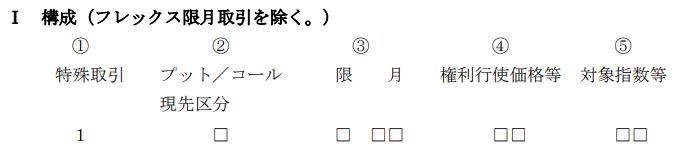

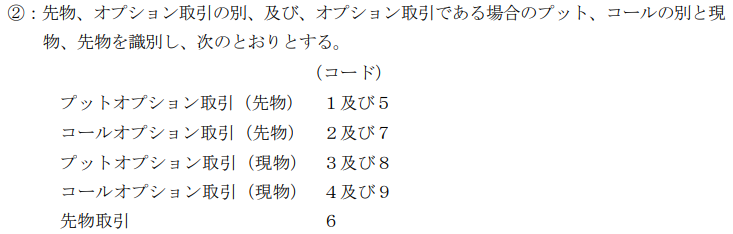

In [ ]:
train_options.head()

In [ ]:
def merge_options(df1, df2) :
    df2["GenSaki"] = df2["OptionsCode"].astype(str).str[1:2]
    df2["TargetIndex"] = df2["OptionsCode"].astype(str).str[5:]

    df2 = df2[df2["TargetIndex"]=="0018"]
    df2 = df2[df2["GenSaki"]== "9"]
    df2 = df2[df2["Putcall"]== 2]
    df2 = df2[["Date", "SettlementPrice", "TheoreticalPrice","ImpliedVolatility"]]
    df2 = df2.groupby("Date").mean().reset_index()    
    df1 = pd.merge(df1, df2, on = "Date", how="left")
    
    return df1

train_prices_options = merge_options(train_prices, train_options)
display(train_prices_options)
del train_prices_options

# (7) Add Options information (for Nikkei225 / Put Put-option)

I tried to add the information related to "Call(buy) the right to call", but tried to add "Put(sell) the right to put" this time.  
I had guessed the result may be almost the same... however, a little bit unexpectedly, Public Score showed **0.077**.  
I'm not sure the reason, but feel this result is a bit interesting.

上記(6)では、「買う権利を買う」情報を加えてみましたが、反対に「売る権利を売る」情報を加えてみます。  
結果は同じだろうな・・・と思ってやってみたのですが、やや意外なことに、Public Scoreは**0.077**へと少し良化しました。  
理由はよく分かりませんが、ちょっと面白い結果かと思います。

In [ ]:
def merge_options(df1, df2) :
    df2["GenSaki"] = df2["OptionsCode"].astype(str).str[1:2]
    df2["TargetIndex"] = df2["OptionsCode"].astype(str).str[5:]

    df2 = df2[df2["TargetIndex"]=="0018"]
    df2 = df2[df2["GenSaki"]== "3"]
    df2 = df2[df2["Putcall"]== 1]
    df2 = df2[["Date", "SettlementPrice", "TheoreticalPrice","ImpliedVolatility"]]
    df2 = df2.groupby("Date").mean().reset_index()    
    df1 = pd.merge(df1, df2, on = "Date", how="left")
    
    return df1

train_prices_options = merge_options(train_prices, train_options)
display(train_prices_options)
del train_prices_options

# Credit

Thanks to below links;

for Ranking/submission method;  
https://www.kaggle.com/code/ikeppyo/jpx-lightgbm-demo

for English explanation of Option code;  
https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/discussion/318048